In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import keras
from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical  


from scipy import ndimage
from random import randint


numbpath = "plate/trainimg/numbers/"
letterpath = "plate/trainimg/letters/"

num_files = os.listdir(numbpath)
let_files = os.listdir(letterpath)

cut_max = (130,255,255)
cut_min=(100, 150,45)

nLabels = [F[0] for F in num_files]
lLabels = [F[0] for F in let_files]

Labels = nLabels + lLabels

enc = LabelEncoder()
enc.fit(Labels)

numClasses = enc.transform(nLabels)
letClasses = enc.transform(lLabels)
Classes = enc.transform(Labels)

def cut_and_blur(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    cut = cv.inRange(hsv, cut_min,cut_max)
    return ndimage.uniform_filter(cut, size=randint(7,17))

#Classes = to_categorical(Classes, num_classes = 36)

numbFrames = [np.array(cv.imread(numbpath + F)) for F in num_files]
letFrames = [np.array(cv.imread(letterpath + F)) for F in let_files]

Frames = numbFrames + letFrames
#print(Frames)
#Frames = [np.delete(x, range(100,110), 1) for x in Frames]
letFrames = [np.reshape(cv.resize(cut_and_blur(x), (64,64)), (64,64,1)) for x in letFrames]
letFrames = np.stack(letFrames).astype(float)/255
numbFrames = [np.reshape(cv.resize(cut_and_blur(x), (64,64)), (64,64,1)) for x in numbFrames]
numbFrames = np.stack(numbFrames).astype(float)/255
Frames = [np.reshape(cv.resize(cut_and_blur(x), (64,64)), (64,64,1)) for x in Frames]
Frames = np.stack(Frames).astype(float)/255

print(Frames.shape)
#Frames = Frames.reshape(Frames.shape[1]*Frames.shape[2]*Frames.shape[3], Frames.shape[0]).T
print(letFrames.shape)

xtrainL, xtestL, ytrainL, ytestL = train_test_split(letFrames, letClasses, test_size = 0.1)
xtrainL, xtestN, ytrainN, ytestN = train_test_split(numbFrames, numClasses, test_size = 0.1)
xtrain, xtest, ytrain, ytest  = train_test_split(Frames, Classes, test_size = 0.1)

Using TensorFlow backend.


(4472, 64, 64, 1)
(2236, 64, 64, 1)


In [30]:
# model = models.Sequential()
# model.add(layers.Conv2D(64, (3, 3), input_shape = (128,128,3), activation='relu',))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(lay ers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(128, activation = 'relu'))
# model.add(layers.Dense(36, activation='softmax'))

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(36, activation='softmax'))

#adam = optimizers.adam(lr= 1e-3)

#train the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(xtrain, ytrain, validation_split = 0.1,
         epochs=15,
         verbose=1)

Train on 3621 samples, validate on 403 samples
Epoch 1/15
3621/3621 [==============================] - 18s 5ms/step - loss: 2.3234 - accuracy: 0.3568 - val_loss: 0.3148 - val_accuracy: 0.9156
Epoch 2/15
3621/3621 [==============================] - 17s 5ms/step - loss: 0.5027 - accuracy: 0.8384 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 3/15
3621/3621 [==============================] - 19s 5ms/step - loss: 0.2153 - accuracy: 0.9249 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/15
3621/3621 [==============================] - 18s 5ms/step - loss: 0.1369 - accuracy: 0.9536 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/15
3621/3621 [==============================] - 18s 5ms/step - loss: 0.1233 - accuracy: 0.9572 - val_loss: 5.8751e-04 - val_accuracy: 1.0000
Epoch 6/15
3621/3621 [==============================] - 14s 4ms/step - loss: 0.0968 - accuracy: 0.9732 - val_loss: 9.8169e-04 - val_accuracy: 1.0000
Epoch 7/15
3621/3621 [==============================] - 14s 4ms/step - loss

In [31]:
pred = model.predict(xtest)
pred = enc.inverse_transform([np.argmax(x) for x in pred])

In [ ]:
testlabels = enc.inverse_transform(ytest)
import sklearn

confmatrix = sklearn.metrics.confusion_matrix(pred, testlabels)
#print(confmatrix)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(confmatrix, index = [i for i in Labels],
                  columns = [i for i in Labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


# for fr in xtest:
#     plt.imshow(fr[:,:,0])
#     title = pred[i]
#     plt.title(title)
#     plt.show() #enc.inverse_transform([pred[i]])+ " " + enc.inverse_transform([ytest[i]]))
#     i += 1

In [ ]:
# import joblib
# import pickle 
# #joblib.dump(model, "cnn.jb")
# with open('cnn.pkl', 'wb') as f:
#     pickle.dump(model,f)
# #joblib.dump(enc, "encoder.jb")


In [ ]:
# model.save('anothermodel_all.h5')

In [ ]:
out = clf.predict(model.predict(xtest))

In [ ]:
print(xtrain.shape[1:]+ (1,))

In [ ]:
model.fit(xtrain, ytrain,
         epochs=25,
         verbose=1)

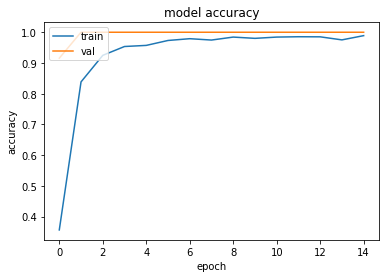

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', ], loc='upper left')
plt.show()

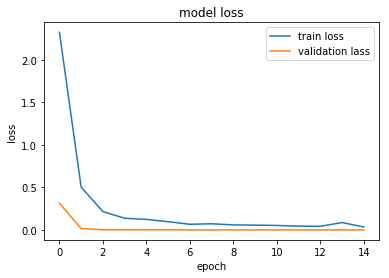

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation lass', ], loc='upper right')
plt.show()